# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [6]:
# dataDir = "/home/ababil/BUET/AV/csv"
# dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"
# dataDir ="C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/location-2"
dataDir = "D:/desktop_alternative/buetav/behavior-hypotheses-main/location-2"


In [7]:
# exec(open('init_notebook.py').read())
# exec(open('C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/src/notebooks/init_notebook.py').read())
exec(open('D:/desktop_alternative/buetav/behavior-hypotheses-main/src/notebooks/init_notebook.py').read())

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
sys.path.append(os.path.abspath('C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/src'))

from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

# from behavior_tools.Testing import TrajectoryTestingCalculator

In [10]:
sceneId = 210
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [11]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()

# testingCalculator = TrajectoryTestingCalculator()
colMapper = ColMapper(
        fps=10,
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        # xAccCol='sceneXAcceleration',
        # yAccCol='sceneYAcceleration',
        speedCol='speed',
        # accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    # minAcceleration = 0.0,
    # maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

In [12]:
xCol="sceneX"
yCol="sceneY"
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate180(trackDf,xCol,yCol)

        # X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


11101

In [13]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,-0.670135,-1.967831
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,-0.679707,-1.870670
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,-0.690215,-1.773153
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,-0.701232,-1.674626
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,-0.712428,-1.575365


In [14]:
# plt.boxplot(startingDf["speed"])

In [15]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

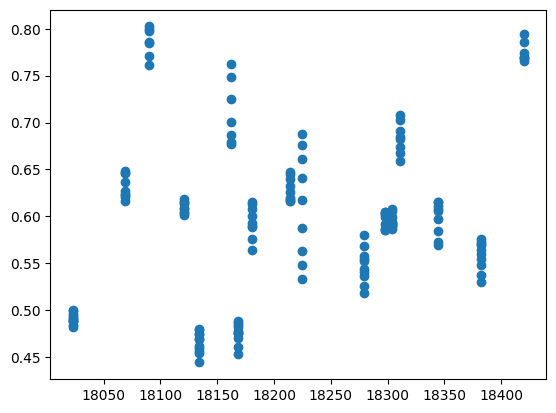

In [16]:
allPedIds
startingEditedDf = startingDf[startingDf["uniqueTrackId"] < 18500].copy()
plt.scatter(startingEditedDf["uniqueTrackId"], startingEditedDf["speed"])
# plt.show()

In [17]:

# plt.scatter(startingEditedDf["displacementY"], startingEditedDf["speed"], marker = ".")


        
# uniqueTrackId_collection = {} 

# for pedId in allPedIds:
#     uniqueTrackId_collection[pedId] = startingEditedDf[startingEditedDf["uniqueTrackId"] == pedId].copy()
#     plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["speed"])
# # plt.show()
# plt.scatter(startingEditedDf["displacementY"], startingEditedDf["acceleration"], marker = ".")
# for pedId in allPedIds:
#     uniqueTrackId_collection[pedId] = startingEditedDf[startingEditedDf["uniqueTrackId"] == pedId].copy()
#     plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["acceleration"])
# # plt.show()

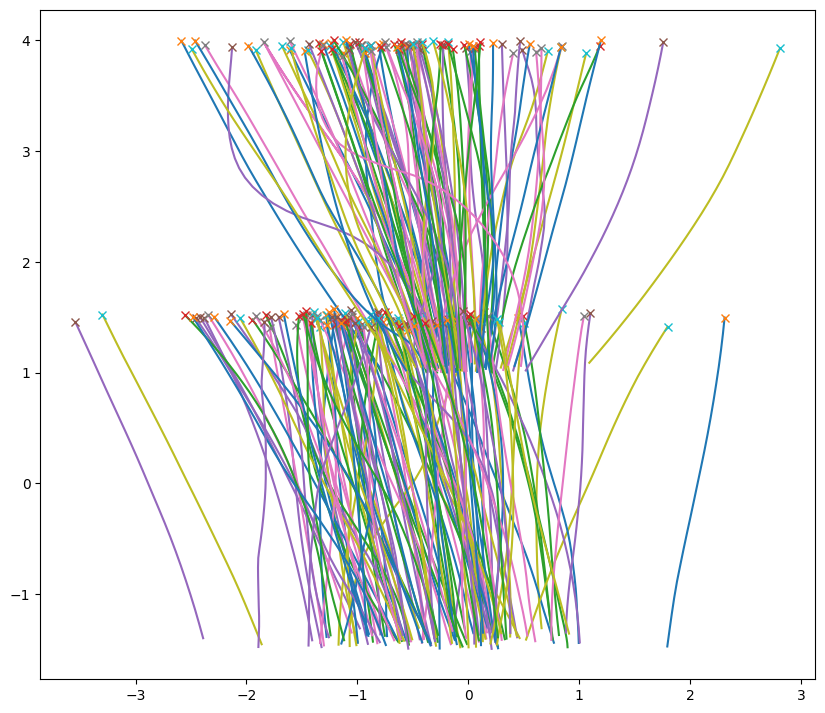

In [18]:
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
visualizer.show(midDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

{'whiskers': [<matplotlib.lines.Line2D at 0x1e177d60450>,
 'caps': [<matplotlib.lines.Line2D at 0x1e100cefb90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e1008d0590>],
 'medians': [<matplotlib.lines.Line2D at 0x1e100d10a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e100281210>],
 'means': []}

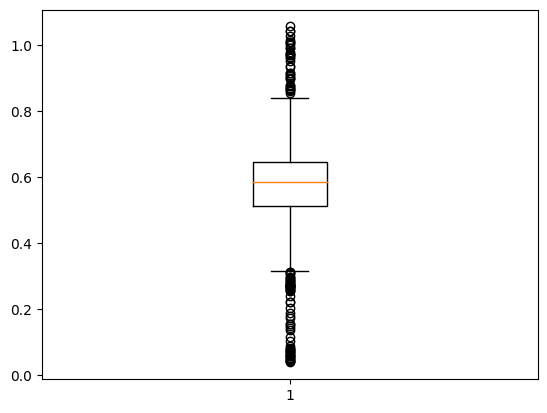

In [19]:
plt.boxplot(startingDf["speed"])

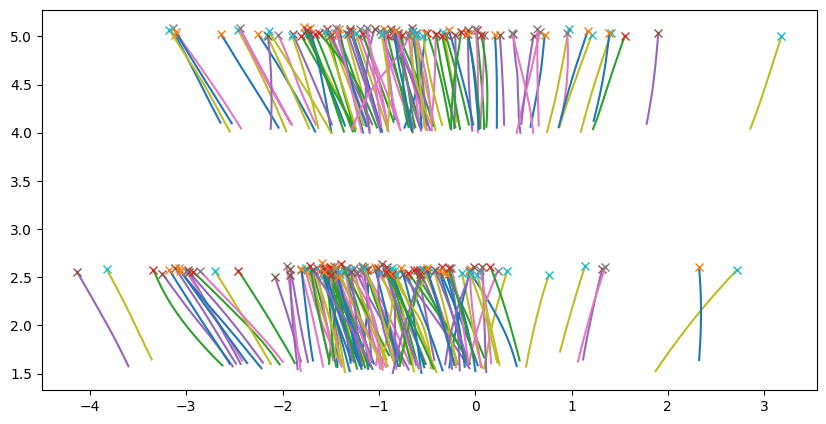

In [20]:
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
visualizer.show(endDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

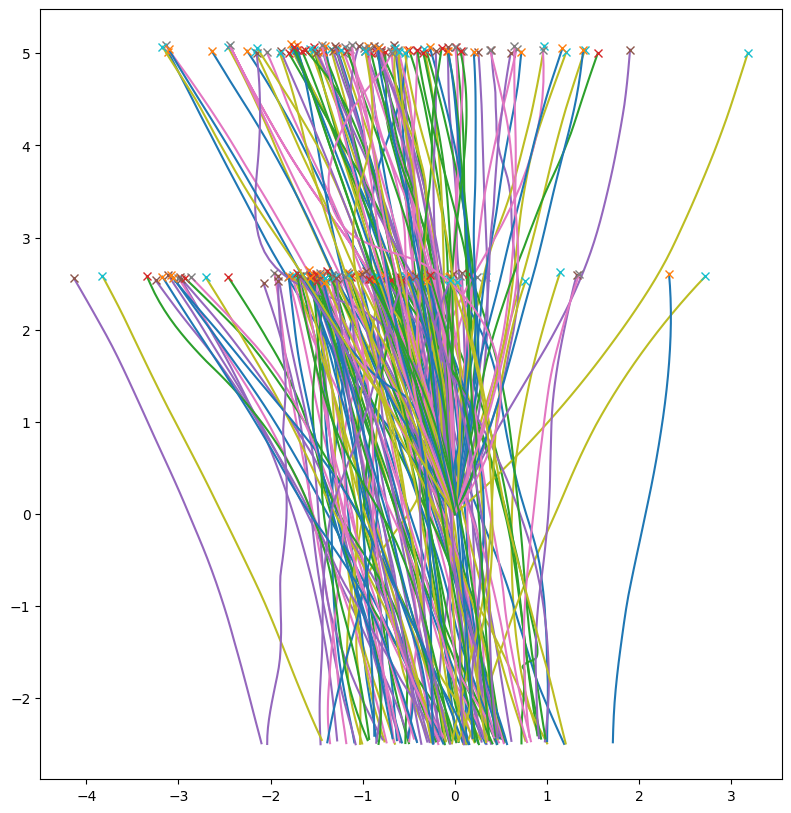

In [21]:

visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

{'whiskers': [<matplotlib.lines.Line2D at 0x1e105430610>,
 'caps': [<matplotlib.lines.Line2D at 0x1e105431490>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e1053d5710>],
 'medians': [<matplotlib.lines.Line2D at 0x1e105421550>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e1053e3790>],
 'means': []}

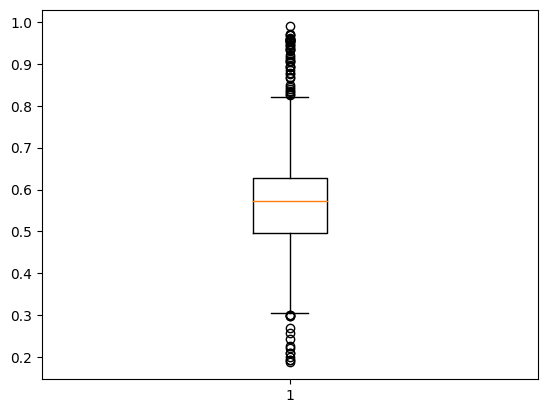

In [22]:
plt.boxplot(endDf["speed"])

<AxesSubplot: xlabel='speed', ylabel='Count'>

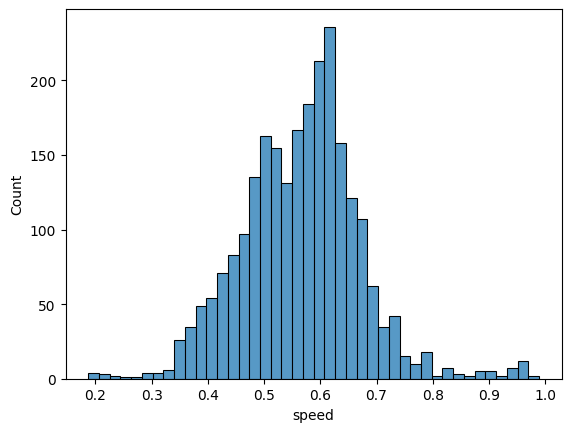

In [23]:
sns.histplot(endDf["speed"])

In [24]:
trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"]==18023]
ade = adeCalculator.getADE(trackDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
ade

0.30499600204316435

In [25]:
aade = adeCalculator.getADE(startingDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
aade

0.6428405152774794

In [26]:
sampler = Sampler()
sampleDf = sampler.getRandom(startingDf, idCol = 'uniqueTrackId', n=10)
aade = adeCalculator.getADE(sampleDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
aade

0.6691980201712598

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

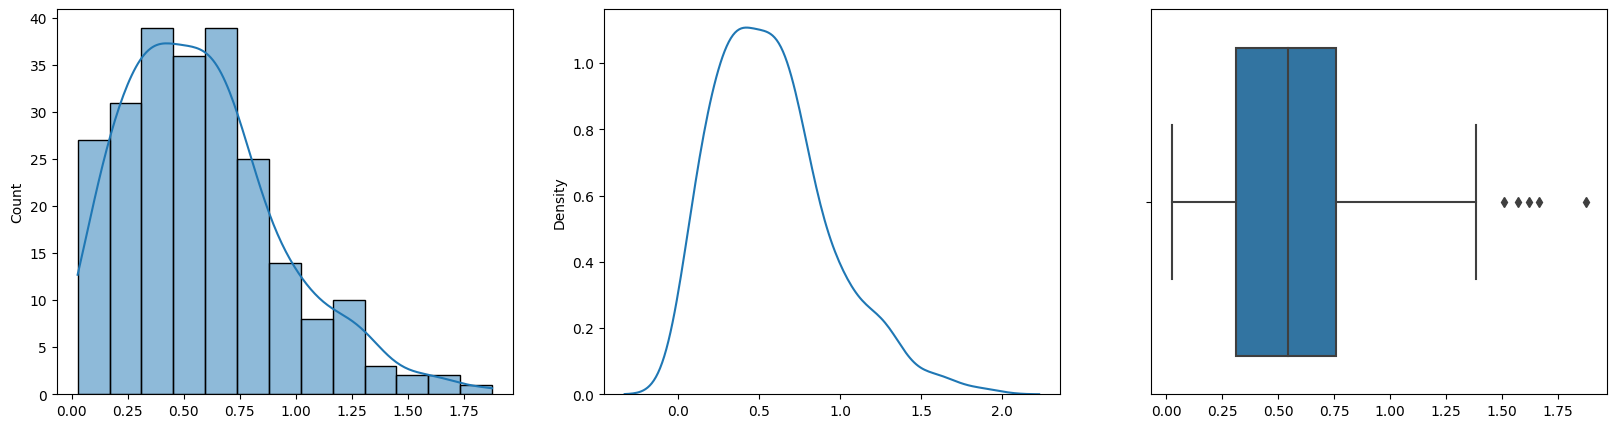

In [27]:
ades = adeCalculator.getADEs(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

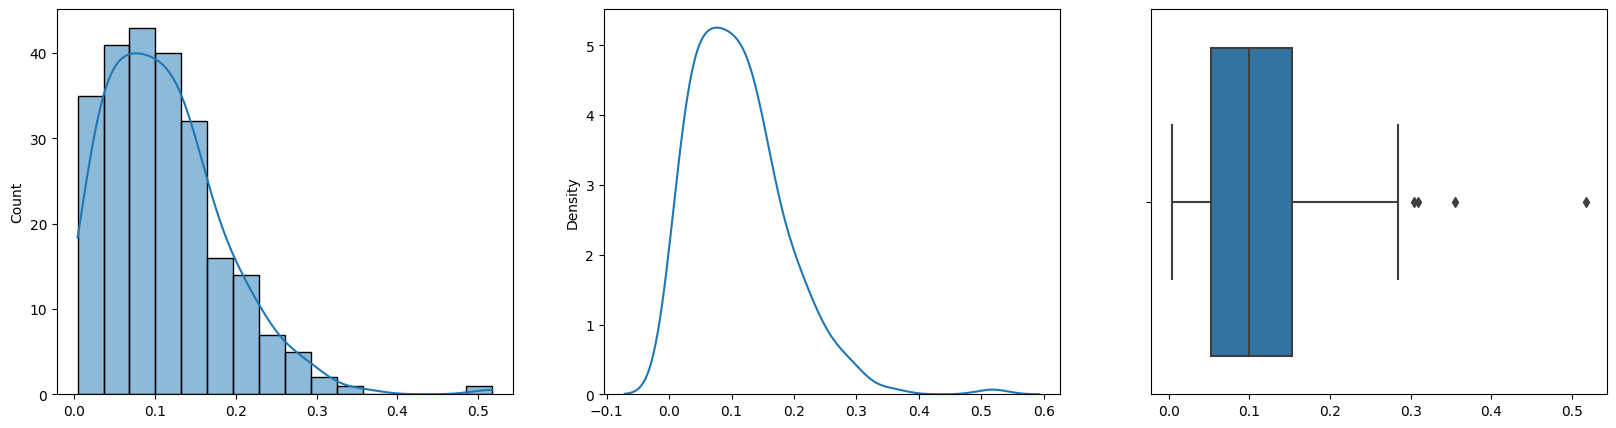

In [28]:
ades = adeCalculator.getADEs(startingDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')


fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

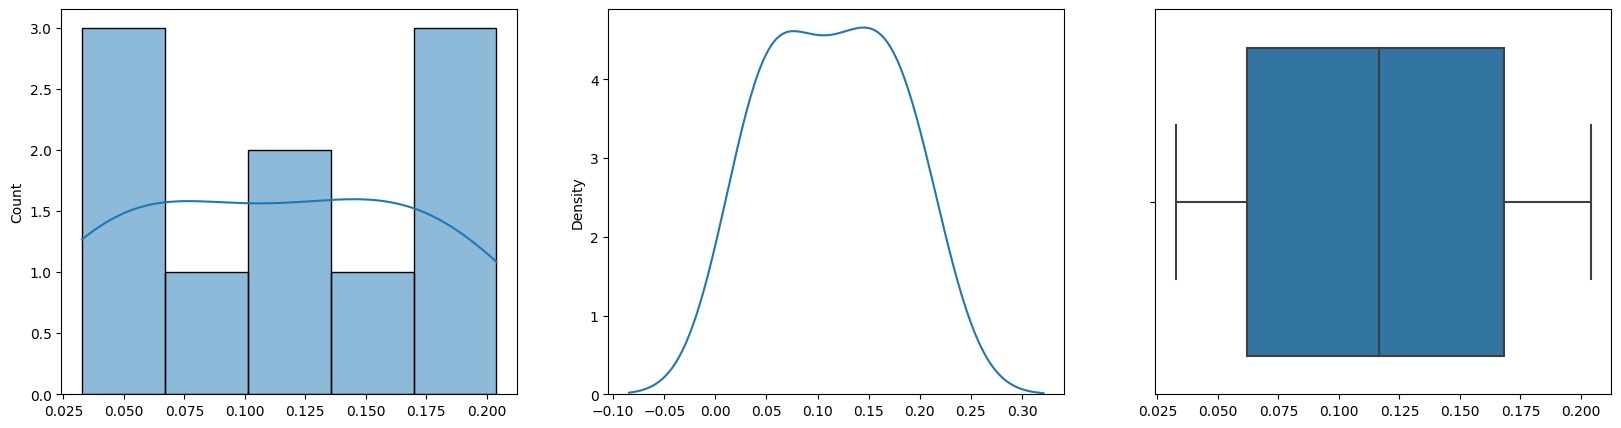

In [29]:
ades = adeCalculator.getADEs(sampleDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

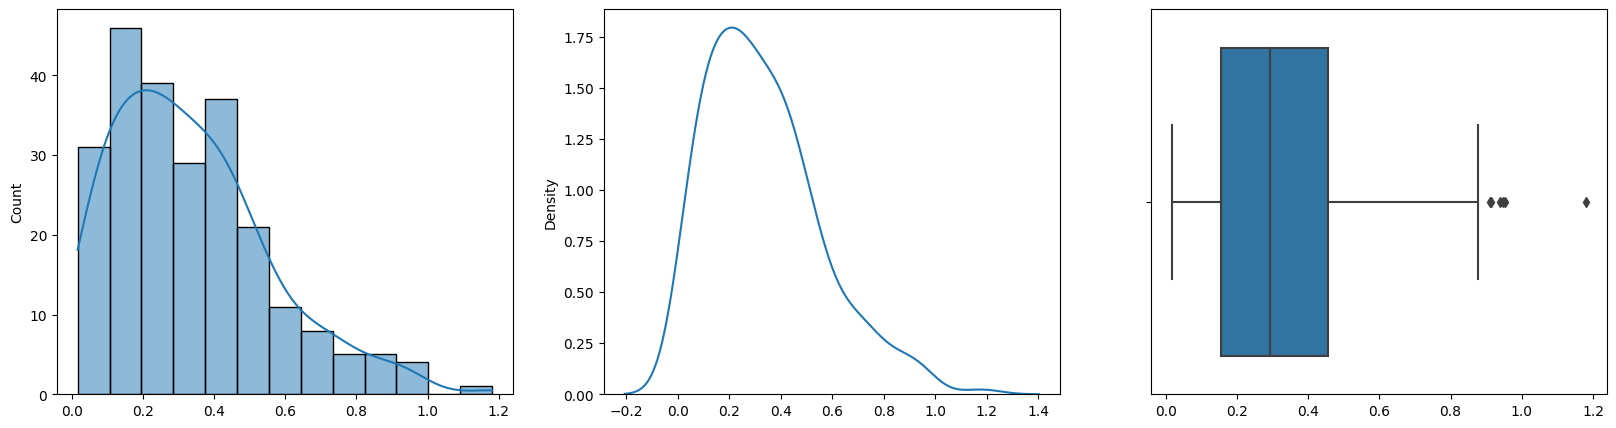

In [30]:
ades = adeCalculator.getADEs(midDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')


fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

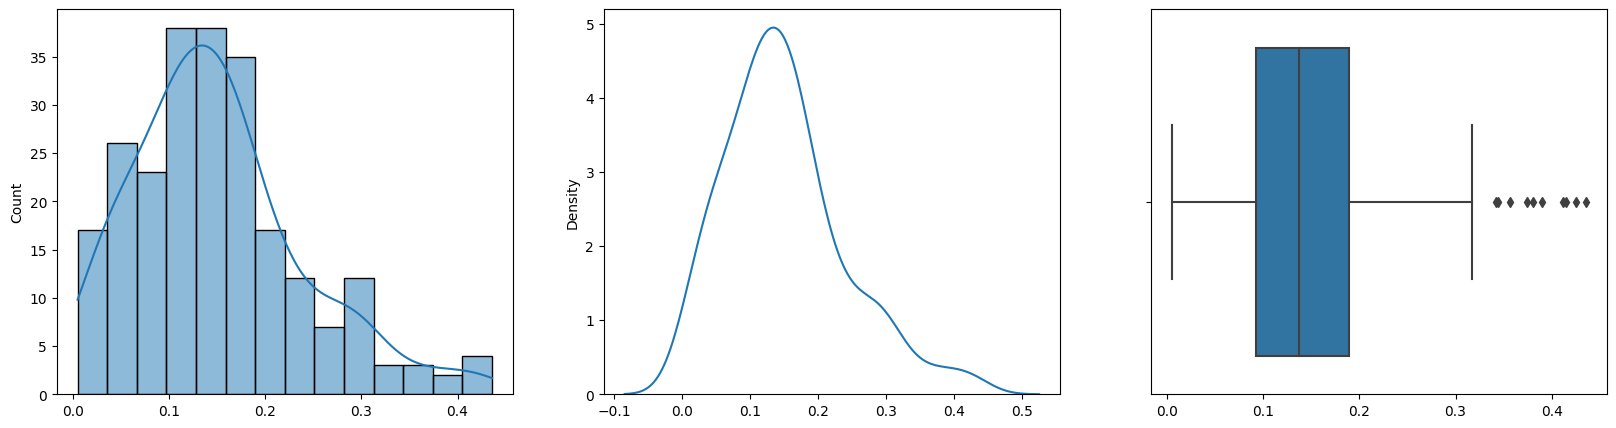

In [31]:
ades = adeCalculator.getADEs(endDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

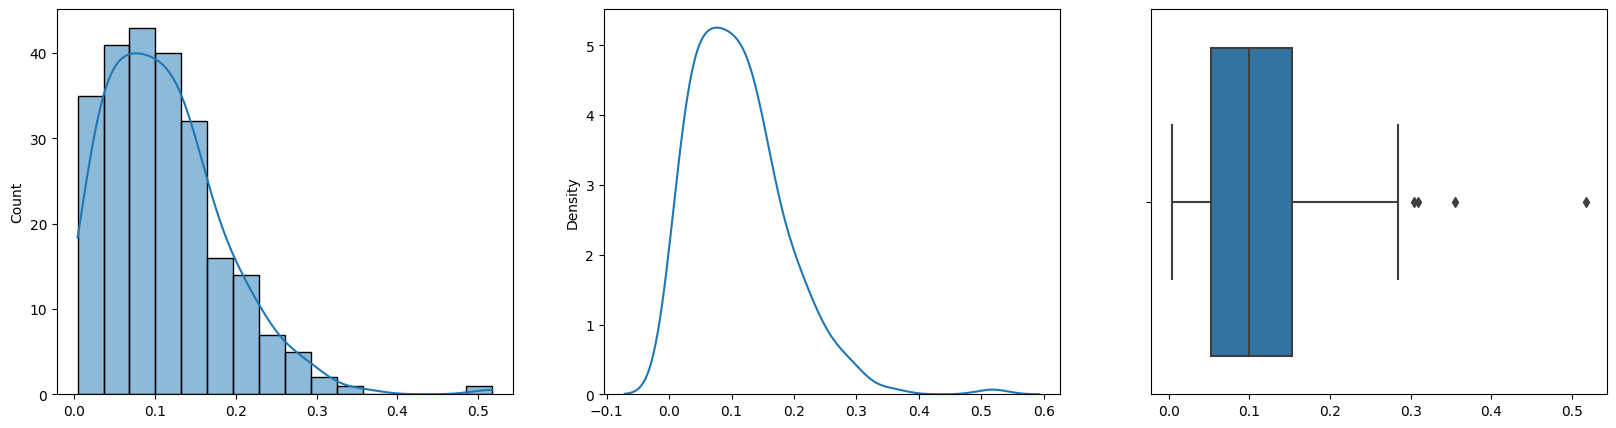

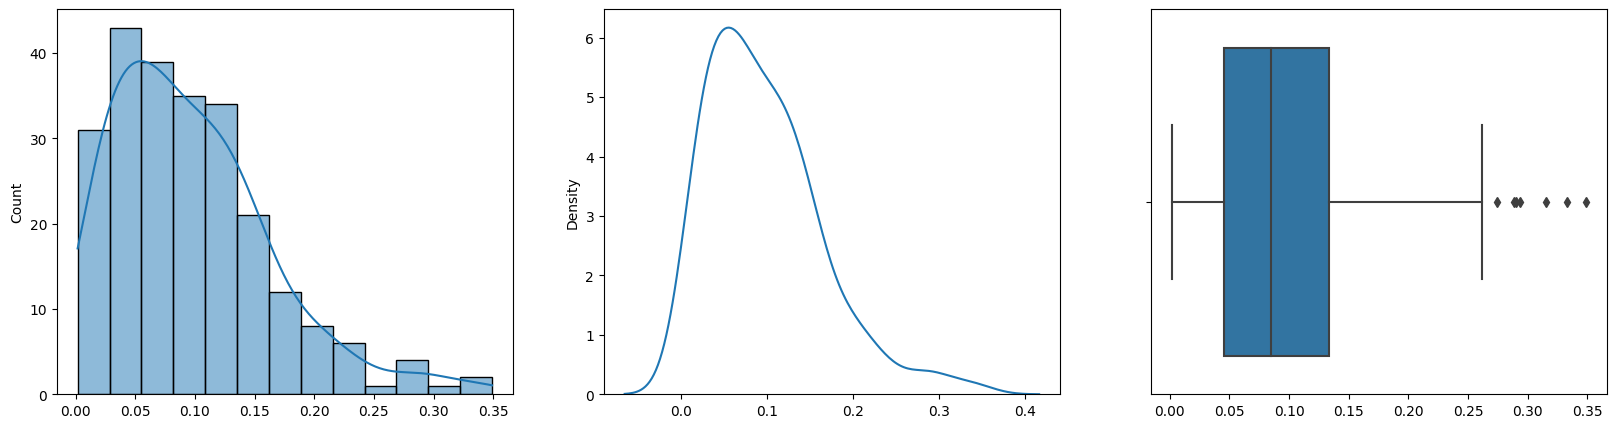

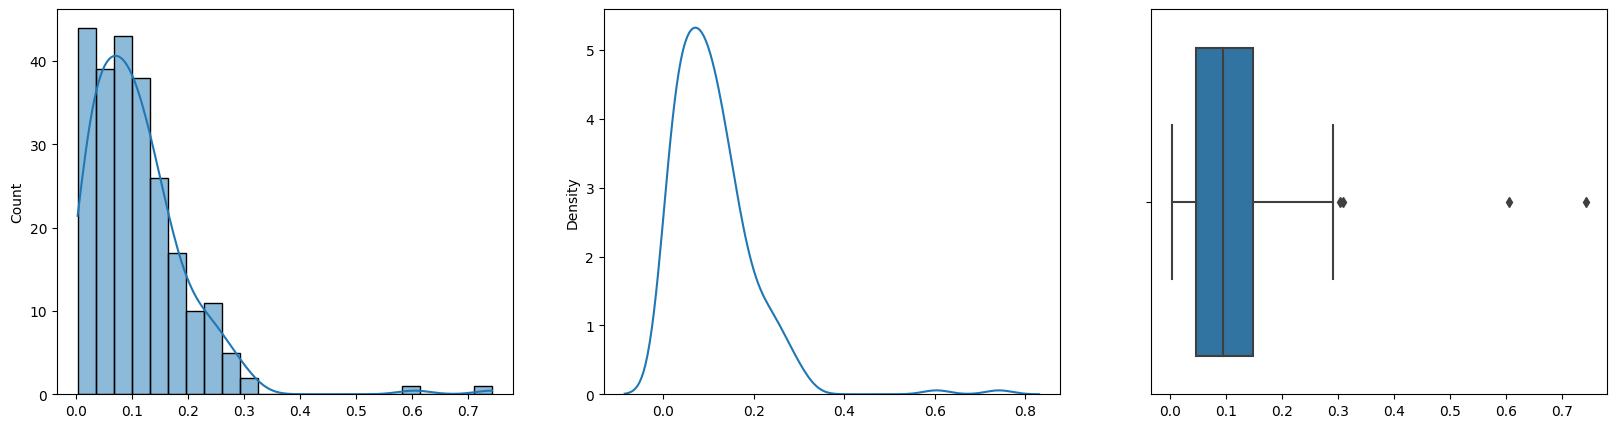

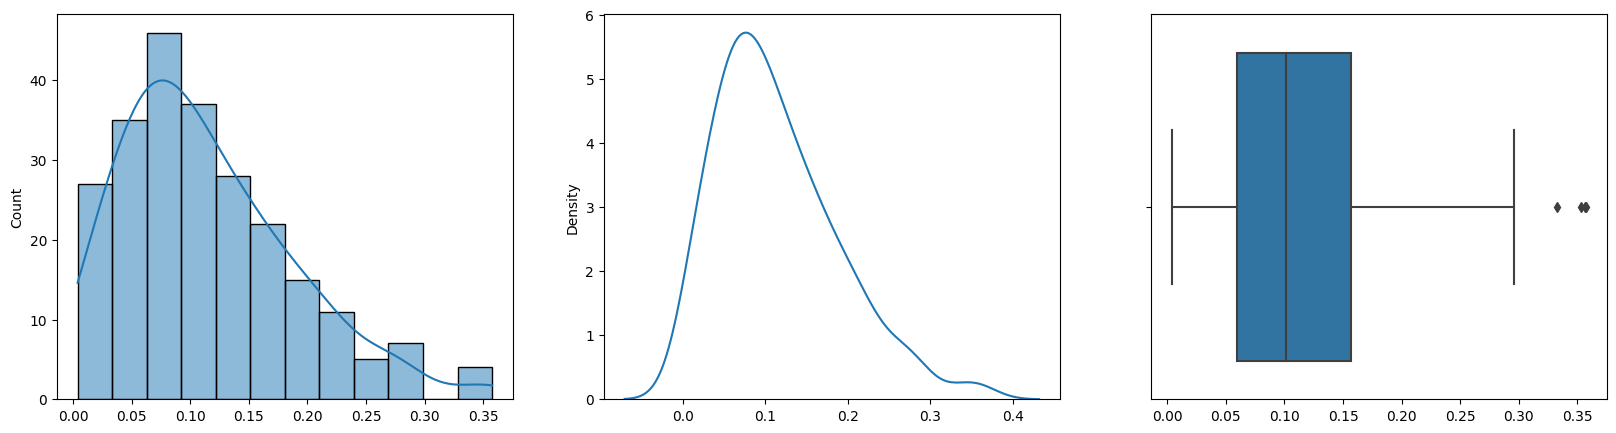

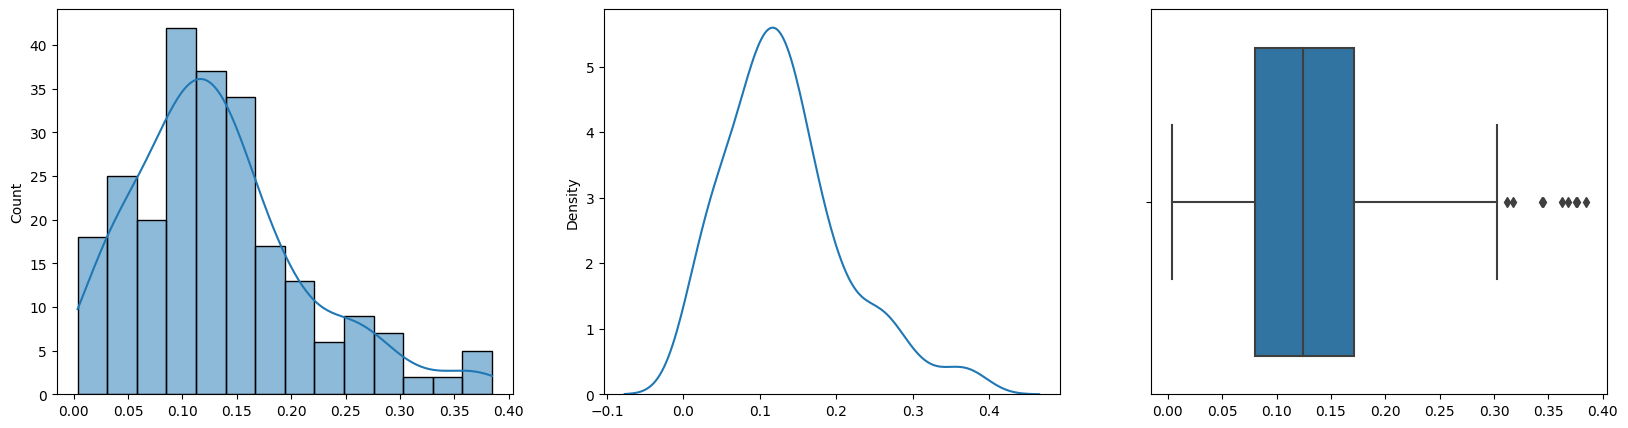

In [32]:
prevD = 0
for d in range(1, 6):
    tracksDf = cleanPedDf[(cleanPedDf["displacementY"] >= prevD) & (cleanPedDf["displacementY"] < d)].copy()
    prevD = d
    ades = adeCalculator.getADEs(tracksDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
    sns.histplot(ades, kde='true', ax=axs[0])
    sns.kdeplot(ades, ax=axs[1])
    sns.boxplot(ades, ax=axs[2])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

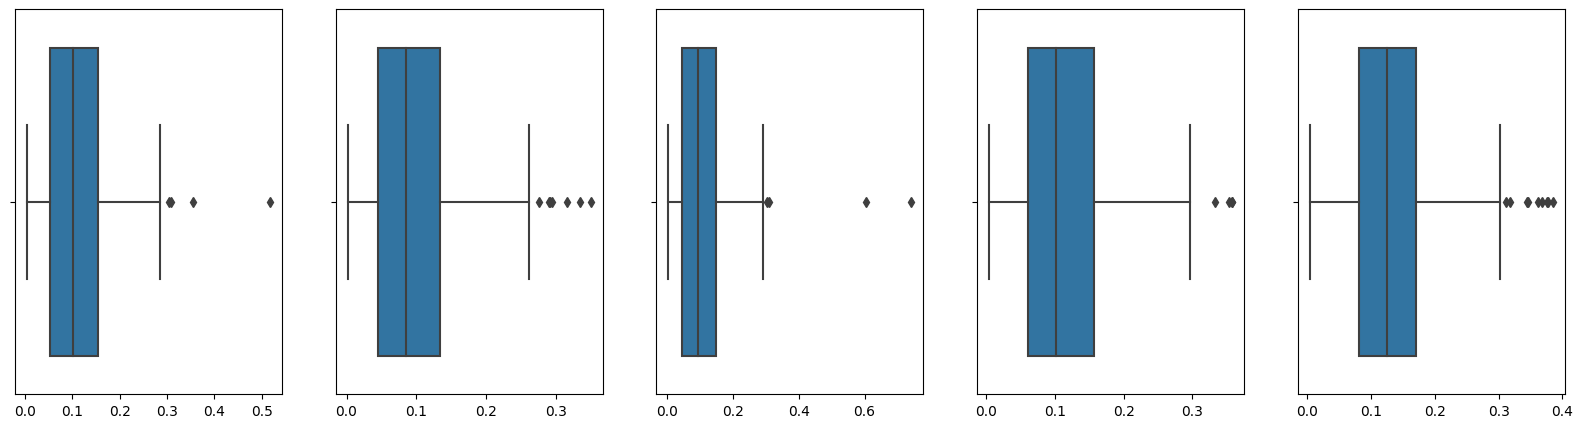

In [33]:
prevD = 0

fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
for d in range(1, 6):
    tracksDf = cleanPedDf[(cleanPedDf["displacementY"] >= prevD) & (cleanPedDf["displacementY"] < d)].copy()
    prevD = d
    ades = adeCalculator.getADEs(tracksDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    sns.boxplot(ades, ax=axs[d-1])

In [34]:
prevD = 0
aades = []
for d in range(1, 6):
    tracksDf = cleanPedDf[(cleanPedDf["displacementY"] >= prevD) & (cleanPedDf["displacementY"] < d)].copy()
    prevD = d
    aades.append(adeCalculator.getAADE(tracksDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY'))
    
print(aades)
# sns.barplot(aades)

[0.11113380180375267, 0.09687668246084043, 0.10845886391846529, 0.11431059236934615, 0.1327475486202378]


In [35]:
import scipy.stats as stats
alpha = 0.05

In [36]:
def findAlphaTAndPToRejectLE(popMean, samples, start=0.0):
    if np.mean(samples) > popMean:
        raise Exception(f"pop mean {popMean} cannot be less than sample mean {np.mean(samples)}") 
    alpha = start
    rejected = False

    t_statistic, p_value = testingCalculator.getTstatistic_pValue_adeslist(samples,popMean)
    increment = 0.00001
    for i in range(100000):
        if p_value / 2 < alpha:
            return alpha, t_statistic, p_value
        alpha += increment
    
    return None, None, None


def findAlphaTAndPToAcceptLE(popMean, samples, start=0.05): 
    if np.mean(samples) > popMean:
        raise Exception(f"pop mean {popMean} cannot be less than sample mean {np.mean(samples)}") 
    alpha = start
    accepted = False

    t_statistic, p_value = testingCalculator.getTstatistic_pValue_adeslist(samples,popMean)
    decrement = 0.00001
    for i in range(100000):
        if p_value / 2 > alpha:
            accepted = True
            break
        alpha -= decrement
    
    if not accepted:
        return None, None, None
    return max(alpha, 0), t_statistic, p_value



def findAlphaTAndPToAcceptGE(popMean, samples, start=0.05): 
    if np.mean(samples) < popMean:
        raise Exception(f"pop mean {popMean} cannot be greater than sample mean {np.mean(samples)}") 
    alpha = start
    accepted = False

    t_statistic, p_value = testingCalculator.getTstatistic_pValue_adeslist(samples,popMean)
    decrement = 0.00001
    for i in range(100000):
        if p_value / 2 > alpha:
            accepted = True
            break
        alpha -= decrement
    
    if not accepted:
        return None, None, None
    # print(alpha)
    return max(alpha, 0), t_statistic, p_value
        
    

In [37]:
ades = adeCalculator.getADEs(startingDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean. testing >=pop mean in starting df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.2, 0.3, 0.5]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptGE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

ades mean. testing >=pop mean in starting df 0.1111338018037527
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
pop mean 0.2 cannot be greater than sample mean 0.1111338018037527
pop mean 0.3 cannot be greater than sample mean 0.1111338018037527
pop mean 0.5 cannot be greater than sample mean 0.1111338018037527


In [38]:
ades = adeCalculator.getADEs(endDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean. testing >=pop mean in end df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.15, 0.3, 0.5]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptGE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

ades mean. testing >=pop mean in end df 0.14991451430240904
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
pop mean 0.15 cannot be greater than sample mean 0.14991451430240904
pop mean 0.3 cannot be greater than sample mean 0.14991451430240904
pop mean 0.5 cannot be greater than sample mean 0.14991451430240904


In [39]:
ades = adeCalculator.getADEs(midDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean. testing >=pop mean in mid df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.15, 0.3, 0.5, 0.56, 0.6, 0.7, 1]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptGE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

ades mean. testing >=pop mean in mid df 0.33292388130353723
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
pop mean 0.5 cannot be greater than sample mean 0.33292388130353723
pop mean 0.56 cannot be greater than sample mean 0.33292388130353723
pop mean 0.6 cannot be greater than sample mean 0.33292388130353723
pop mean 0.7 cannot be greater than sample mean 0.33292388130353723
pop mean 1 cannot be greater than sample mean 0.33292388130353723


In [40]:
ades = adeCalculator.getADEs(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean. testing >=pop mean in whole df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.15, 0.3, 0.5, 0.56, 0.6, 0.7, 1]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptGE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

ades mean. testing >=pop mean in whole df 0.5800480262930185
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
pop mean 0.6 cannot be greater than sample mean 0.5800480262930185
pop mean 0.7 cannot be greater than sample mean 0.5800480262930185
pop mean 1 cannot be greater than sample mean 0.5800480262930185


In [41]:
ades = adeCalculator.getADEs(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean testing <= pop mean whole df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 1]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptLE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

ades mean testing <= pop mean whole df 0.5800480262930185
pop mean 0.0 cannot be less than sample mean 0.5800480262930185
pop mean 0.1 cannot be less than sample mean 0.5800480262930185
pop mean 0.2 cannot be less than sample mean 0.5800480262930185
pop mean 0.3 cannot be less than sample mean 0.5800480262930185
pop mean 0.5 cannot be less than sample mean 0.5800480262930185
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined


In [42]:
ades = adeCalculator.getADEs(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean testing <= pop mean", np.mean(ades))
for population_mean in [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 1]:
    try:
        alpha, t, p = findAlphaTAndPToRejectLE(population_mean, ades)
        rejected = "rejected" if alpha is not None else "accepted"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

ades mean testing <= pop mean 0.5800480262930185
pop mean 0.0 cannot be less than sample mean 0.5800480262930185
pop mean 0.1 cannot be less than sample mean 0.5800480262930185
pop mean 0.2 cannot be less than sample mean 0.5800480262930185
pop mean 0.3 cannot be less than sample mean 0.5800480262930185
pop mean 0.5 cannot be less than sample mean 0.5800480262930185
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
name 'testingCalculator' is not defined
